## Unsupervised Satellite Imagery Classification

Code inspiration from https://github.com/syamkakarla98/Satellite_Imagery_Analysis and the documentation

Data from https://www.sentinel-hub.com/explore/eobrowser/

In [33]:
# necessary installations to be aware of: earthpy, gdal, plotly==5.10.0, rasterio

In [25]:
from glob import glob

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [26]:
# Reading in bands:

sentinel_bands = glob("./data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B*_(Raw).tiff")
sentinel_bands.sort()
sentinel_bands

['./data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B01_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B02_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B03_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B04_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B05_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B06_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B07_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B08_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B09_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-2_L2A_B11_(Raw).tiff',
 './data/EO_Browser_images/2022-09-23-00:00_2022-09-23-23:59_Sentinel-

In [27]:
# Opening the tiffs with rasterio

l = []
for i in sentinel_bands:
  with rio.open(i, 'r') as f:
    l.append(f.read(1))

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [28]:
# Creating a numpy array stack of the band data:

arr_st = np.stack(l)

In [29]:
# Inspecting the stack dimensions:

print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 737
Width: 1250
Bands: 11


### Visualizing Data

#### Bands

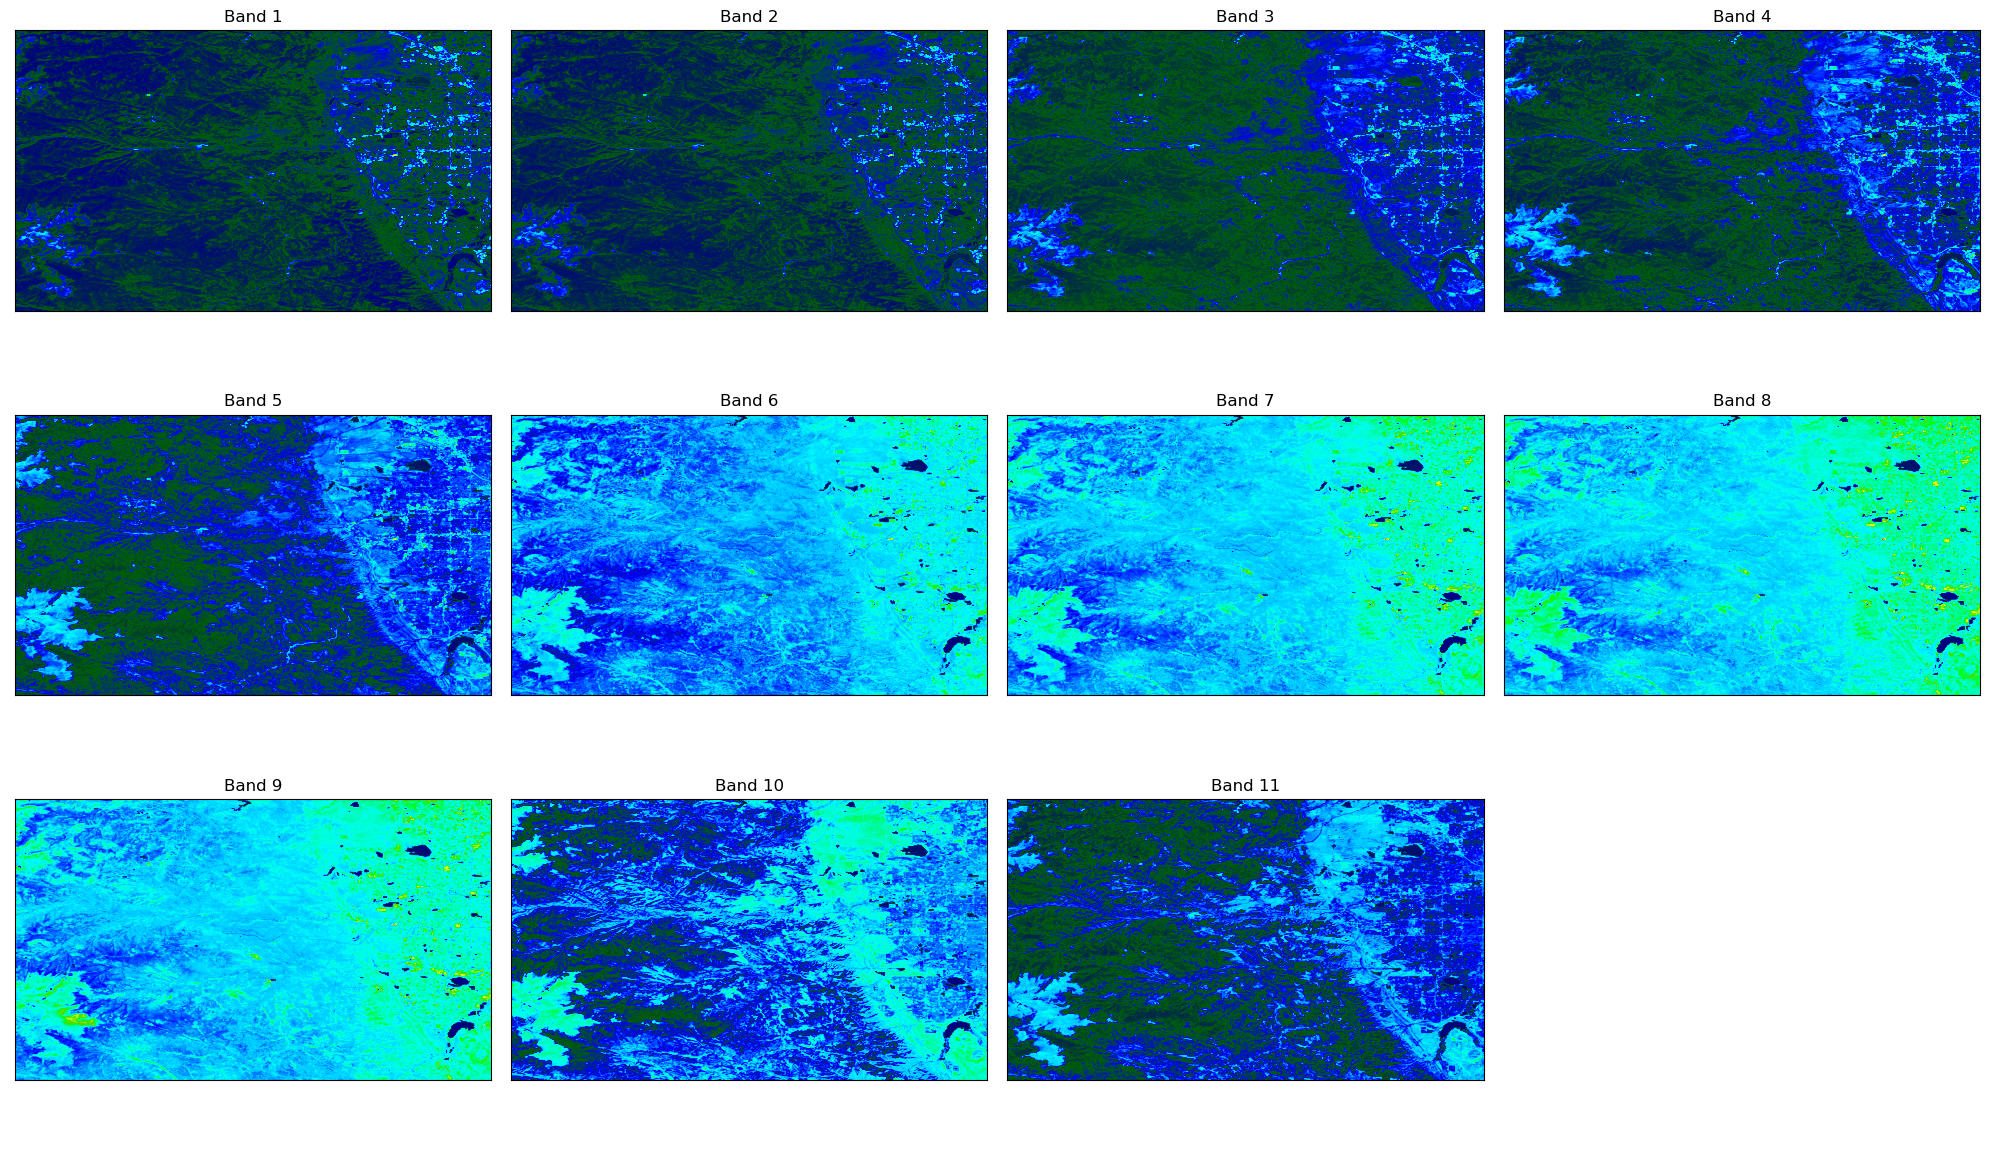

In [30]:
ep.plot_bands(arr_st, cmap = 'gist_ncar', figsize = (20, 12), cols = 4, cbar = False)
plt.show()

#### RGB Composite Image

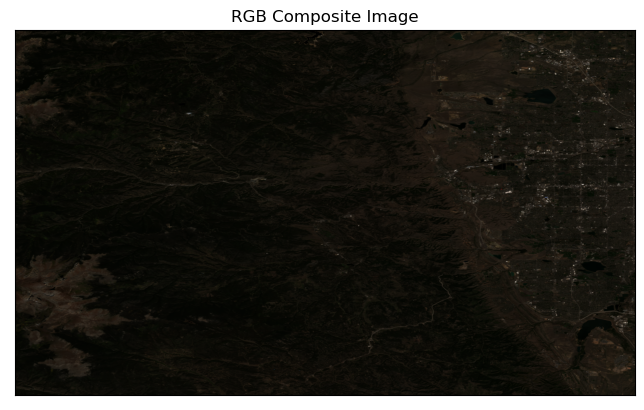

In [7]:
rgb = ep.plot_rgb(arr_st, 
                  rgb=(3,2,1), 
                  figsize=(8, 10), 
                  title='RGB Composite Image'
                  )

plt.show()

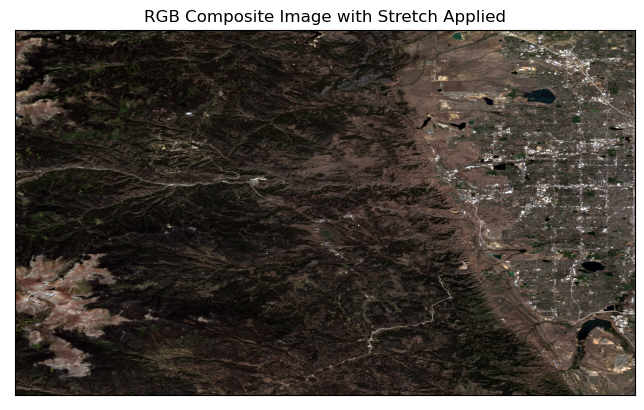

In [8]:
# Composite images can sometimes be dark if the pixel brightness values are skewed toward the value of zero
# so 'stretch=True' shows a better contrast for visualization when the full pixel range 0-255 is used

ep.plot_rgb(
    arr_st,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.2,
    figsize=(8, 10),
    title="RGB Composite Image with Stretch Applied"
)

plt.show()

#### Data Distribution of Bands

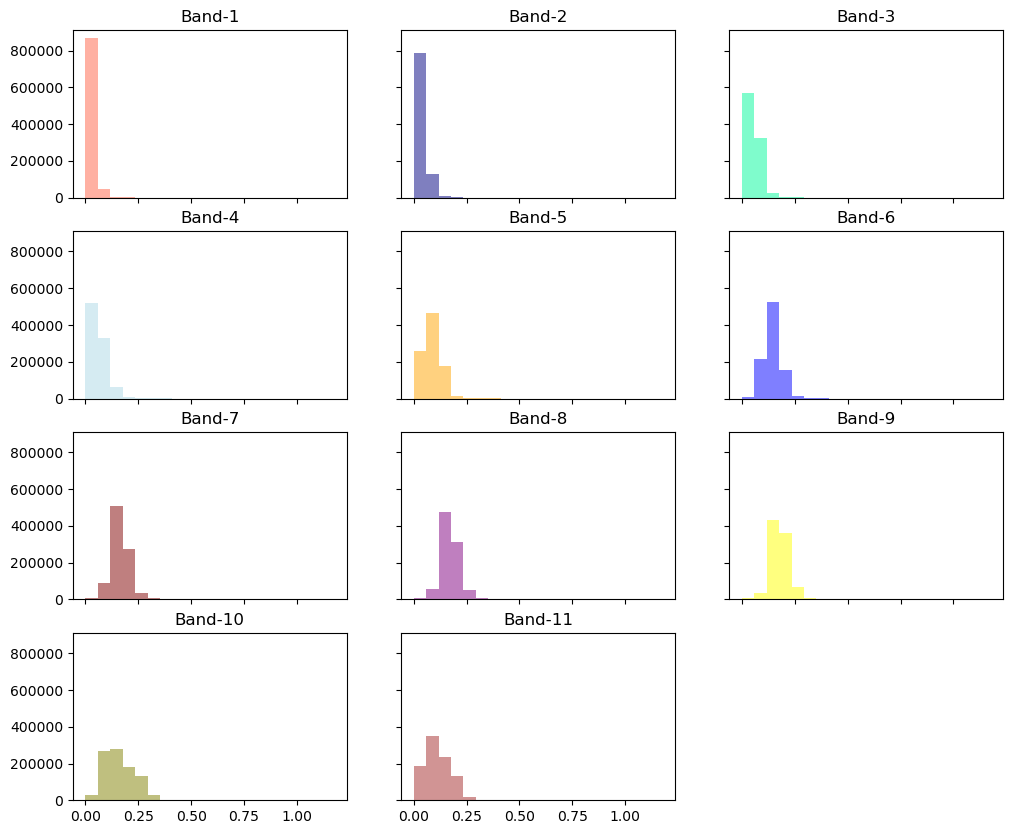

In [10]:
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

ep.hist(arr_st, 
         colors = colors,
        title=[f'Band-{i}' for i in range(1, 12)], 
        cols=3, 
        alpha=0.5, 
        figsize = (12, 10)
        )

plt.show()

### Preprocessing

In [11]:
# Setting our 'X' and moving the axis of the array 

x = np.moveaxis(arr_st, 0, -1)
x.shape

(737, 1250, 11)

In [12]:
# Reshaping our x and confirming that it's the desired shape:

x.reshape(-1, 11).shape, 737*1250

((921250, 11), 921250)

In [13]:
# Standard scaling our X for modeling:

X_data = x.reshape(-1, 11)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(921250, 11)

### Principal Component Analysis (PCA)
- Dimensionality reduction

In [14]:
# Instantiating, fitting, and transforming our X:

pca = PCA(n_components = 4)

pca.fit(X_scaled)

data = pca.transform(X_scaled)

In [15]:
data.shape

(921250, 4)

In [16]:
pca.explained_variance_ratio_

array([0.7926448 , 0.1500059 , 0.04652575, 0.0046601 ])

In [17]:
# Confirming that our sum of explained variance ratio's adds up to ~1:

np.sum(pca.explained_variance_ratio_)

0.9938365453878296

#### Visualize Bands after PCA

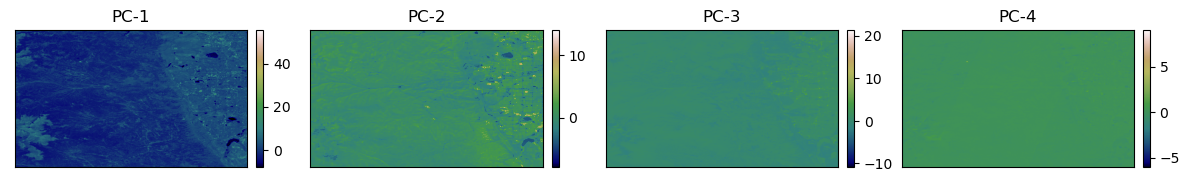

In [18]:
ep.plot_bands(np.moveaxis(data.reshape((737, 1250, data.shape[1])), -1, 0),
              cmap = 'gist_earth',
              cols = 4,
              title = [f'PC-{i}' for i in range(1,5)])

plt.show()

## k-Means

Clustering the data

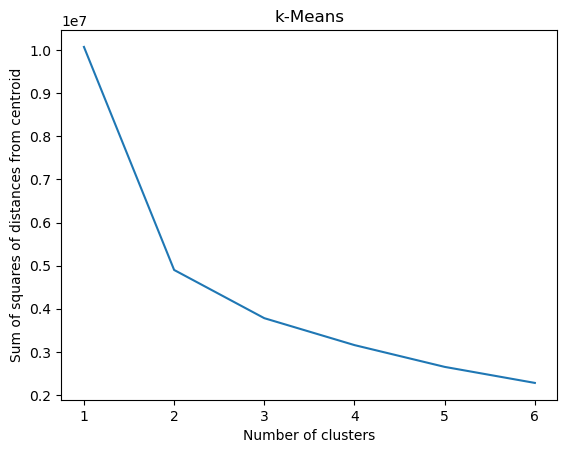

In [19]:
wcss=[]
for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss)
plt.title('k-Means')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares of distances from centroid');

In [20]:
# Instatiating KMeans and fitting on our PCA data
# Since there is no clear "elbow" in the above plot, I chose 4 clusters as ideal.

kmeans = KMeans(n_clusters=4, random_state = 42)

kmeans.fit(data)

KMeans(n_clusters=4, random_state=42)

In [21]:
labels = kmeans.predict(data)

In [22]:
np.unique(labels)

array([0, 1, 2, 3], dtype=int32)

#### Visualize Clusters

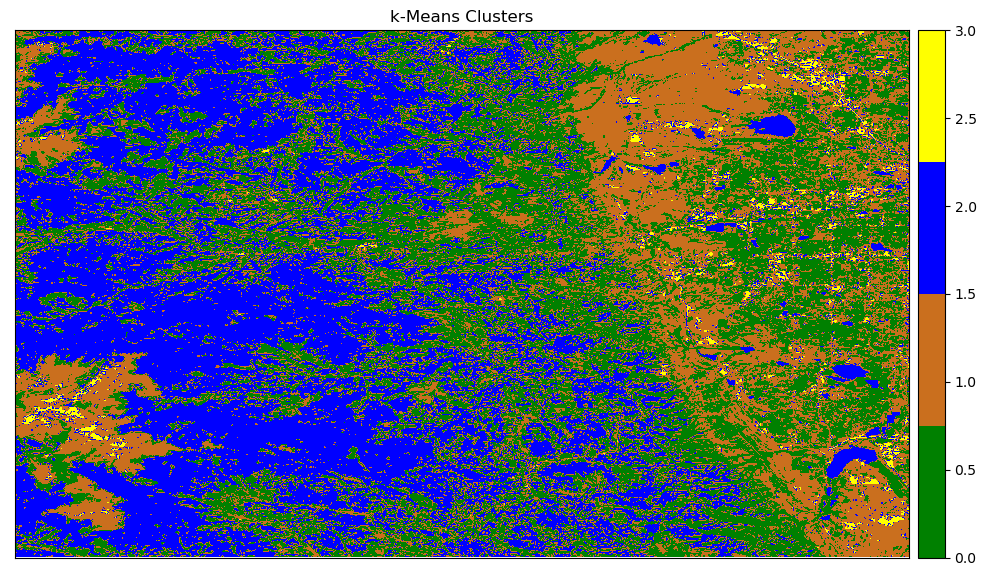

In [24]:
ep.plot_bands(labels.reshape(737, 1250), cmap=ListedColormap(['green', '#CA6F1E', 'blue', 'yellow']), title="k-Means Clusters")
plt.show()

Below is the classification map from the SENTINEL-2 Level-2A processing products. While there is a similar overall pattern, it's clear that the SENTINEL-2 classification algorithm is more advanced, and appears to do a significantly better job at classification. However, for the relative simplicity of kMeans in comparison to the SENTINEL-2 process, it achieves impressive results.

![EO Browser classification](images/EO_Browser_classification.jpg)